### 1. Workspace setup

To connect to the Azure Quantum service, construct an instance of the `AzureQuantumProvider`. Note that it's imported from `azure.quantum.qiskit`.

In [11]:
# Initialize a remote provider
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    # resource_id = "/subscriptions/ff9a6cc5-404e-46a3-93db-935b6dd3c855/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/SirCato",
    resource_id = "/subscriptions/77735dcf-8540-4514-b04a-b34ff5d0774e/resourceGroups/Azure-quantum-credits/providers/Microsoft.Quantum/Workspaces/EntangledNetworksQuantumCredits",
    location = "eastus"
)

In [ ]:
# Query available backends
print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

In [8]:
# backend = provider.get_backend('quantinuum.hqs-lt-s1')
# backend = provider.get_backend('honeywell.hqs-lt-s1-apival')
backend = provider.get_backend('ionq.simulator')

In [4]:
from qiskit.compiler import transpile
import qiskit.circuit as qc

In [10]:
testqc = qc.QuantumCircuit(21)
for i in range(21):
    testqc.h(i)

for i in range(21):
    for j in range(i+1, 21):
        testqc.cx(i,j)
        
testqc2 = transpile(testqc, backend=backend)

In [1]:
# Alternatively use only IBMQ provider
import qiskit.providers.aer as aer
import qiskit.providers.aer.noise as noise
provider = aer.AerProvider()
backend = provider.get_backend('aer_simulator')

In [59]:
noise_model = noise.NoiseModel()
noise_depol = noise.depolarizing_error(0.3,1)
noise_model.add_all_qubit_quantum_error(noise_depol, ['delay'])

In [58]:
noise_model.add_all_qubit_quantum_error?

### 2. User program begins.

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pickle as pck
from copy import deepcopy

import qiskit.circuit as qc
from qiskit.compiler import assemble, transpile
from qiskit.ignis import verification as ver
# from qiskit_experiments.library import tomography as tomo
from qiskit.result import Result
from qiskit.result.models import ExperimentResult

from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(linewidth=400, precision=5, floatmode='maxprec')
from scipy.linalg import fractional_matrix_power as fmpow

os.chdir("/Users/edrazor/Repos/local/QCrap")
import schur

In [21]:
# =============================================== #
# >>> Construct a QISkit data compression obj <<< #
# =============================================== #

# cr = qc.ClassicalRegister(3,'cr_main')
qr = qc.QuantumRegister(3,'qr_main')
uc = qc.QuantumCircuit(qr)

# Random state preparation.
# rnd_alpha,rnd_beta = (2*np.random.rand(2)-1)*np.pi
rnd_alpha,rnd_beta = (1.2063775553886291,-2.9212024620162875)
print("alpha: ", rnd_alpha, "; beta: ", rnd_beta)

# State prep.
uc.ry(rnd_alpha,0)
uc.ry(rnd_alpha,1)
uc.ry(rnd_alpha,2)
uc.rz(rnd_beta,0)
uc.rz(rnd_beta,1)
uc.rz(rnd_beta,2)
uc.delay(1)

# Main data-compression unitary.
uc = schur.genCompression(uc)

# For use with QISkit Ignis.
uc_tomo = ver.tomography.state_tomography_circuits(uc, [0,1,2])

# For use with qiskit-experiments (replacement for Ignis)
# uc_tomo = tomo.StateTomography(uc)

alpha:  1.2063775553886291 ; beta:  -2.9212024620162875


In [22]:
#======================================================#
# >>> Re-compile with QISkit to set of basis gates <<< #
#======================================================#
# nShots = 8192*10
nShots = 512

# Nairobi-specific backend specs
cmap = backend.configuration().coupling_map
bgates = backend.configuration().basis_gates

# Specify basis gates that we want to work with
# bgates = ['rz','rx','ry','cx','rzz','crz','h','x','y','z']

# 1st round of transpile, replace Toffolis etc. with basis gate decomp
uc_native = transpile(uc_tomo, basis_gates=bgates, optimization_level=0)
jobs = transpile(uc_native,backend=backend,optimization_level=3,basis_gates=bgates,coupling_map=cmap)#,scheduling_method='alap')

jobs = jobs[0:2]

In [ ]:
# Estimate runtime cost
cost = []
for idx,job in enumerate(jobs):
    cost.append(backend.estimate_cost(job,shots=nShots))
    print(cost[idx].estimated_total)
# print(np.sum([entry.estimated_total for entry in cost]))

In [19]:
# Submit for execution
jobInstance = []
jobID = []
for job in jobs:
    job_instance = backend.run(job,shots=nShots)#,noise_model=noise_model)
    jobInstance.append(job_instance)

shots is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
shots is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored


In [ ]:
# Retrieve results
jobResults = []
for job in jobInstance:
    jobResults.append(job.result())

In [101]:
fitter = ver.tomography.fitters.state_fitter.TomographyFitter(jobResults,jobs)
rho_targ = fitter.fit(trace=1,trace_preserving=True)

print("Trace: ", np.trace(rho_targ))

Trace:  (1+0j)


## Re-construction

In [22]:
# Read in existing data.
os.chdir("/Volumes/OpenStorage/temp/Compression")
handle = open('fullBasic-honeywellsim-random2a.txt','rb')
pck.dump(jobResults, handle)
jobResults = pck.load(handle)
handle.close()

# Optionally read in Aer stuff, to pad incomplete Honeywell data.
handle = open('fullBasic-aersim-random2a.txt','rb')
pck.dump(jobResultsAer, handle)
jobResultsAer = pck.load(handle)
handle.close()

In [25]:
def pad(str_in, padchar, length=1, mode='prepend'):
    '''
    Pad str_in up to length.
    '''
    if len(str_in)>=length:
        return str_in
    elif mode=='prepend':
        return (length-len(str_in))*padchar+str_in
    elif mode=='append':
        return str_in + (length-len(str_in))*padchar

In [26]:
def qiskit_result_setdata(old_result, new_experimentresult):
    tempcount = {}
    tempprob = {}
    shots = new_experimentresult['shots']

    for key in new_experimentresult['data']['counts']:
        count = new_experimentresult['data']['counts'][key]
        keybin = pad(bin(int(key,16))[2:], '0', length=3)
        tempcount.update({keybin:count})
        tempprob.update({keybin:count/shots})

    old_result['qobj_id'] = new_experimentresult['header']['name']
    old_result['results'][0]['header']['name'] = new_experimentresult['header']['name']
    old_result['results'][0]['shots'] = shots

    old_result['results'][0]['data']['counts'] = tempcount
    old_result['results'][0]['data']['probabilities'] = tempprob
    

In [27]:
def qiskit_result_append(result, new_experimentresult, template):
    for obj in new_experimentresult:
        targ_dict = deepcopy(template.to_dict())
        src_dict = obj.to_dict().copy()
        
        qiskit_result_setdata(targ_dict, src_dict)
        result.append(Result.from_dict(targ_dict))

        del(targ_dict)
        del(src_dict)

In [ ]:
qiskit_result_append(jobResults, jobResultsAer[15:20], jobResults[0])

In [102]:
coords_base = np.array([0,1,2,3,4,5,6,7]).flatten()
coordX = np.repeat([coords_base],8,axis=0).flatten()
coordY = np.repeat([coords_base],8,axis=1).reshape((-1,8)).flatten()
coordZ = np.zeros((8,8)).flatten()
dX=dY=(np.ones((8,8))*0.9).flatten()
dZ_targ_abs = np.abs(rho_targ).flatten()
dZ_targ_re = np.real(rho_targ).flatten()
dZ_targ_im = np.imag(rho_targ).flatten()

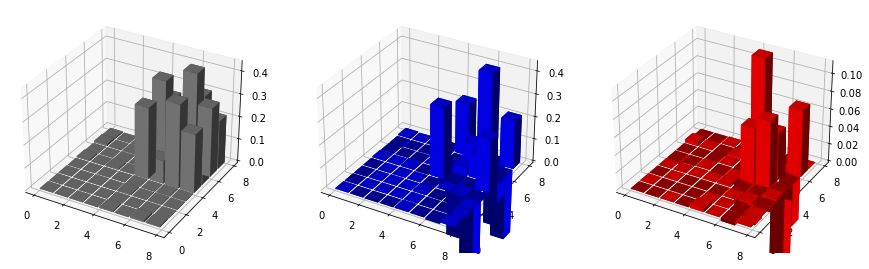

In [25]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131,projection='3d')
ax2 = fig.add_subplot(132,projection='3d')
ax3 = fig.add_subplot(133,projection='3d')

ax1.bar3d(coordX,coordY,coordZ,dX,dY,dZ_targ_abs,color='grey')
ax2.bar3d(coordX,coordY,coordZ,dX,dY,dZ_targ_re,color='blue')
ax3.bar3d(coordX,coordY,coordZ,dX,dY,dZ_targ_im,color='red')
plt.show()

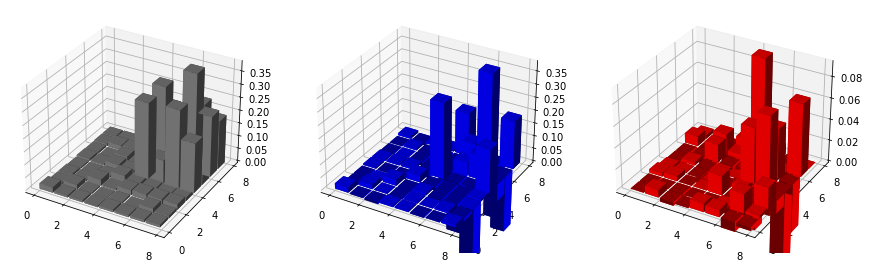

In [26]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131,projection='3d')
ax2 = fig.add_subplot(132,projection='3d')
ax3 = fig.add_subplot(133,projection='3d')

ax1.bar3d(coordX,coordY,coordZ,dX,dY,dZ_exp_abs,color='grey')
ax2.bar3d(coordX,coordY,coordZ,dX,dY,dZ_exp_re,color='blue')
ax3.bar3d(coordX,coordY,coordZ,dX,dY,dZ_exp_im,color='red')
plt.show()

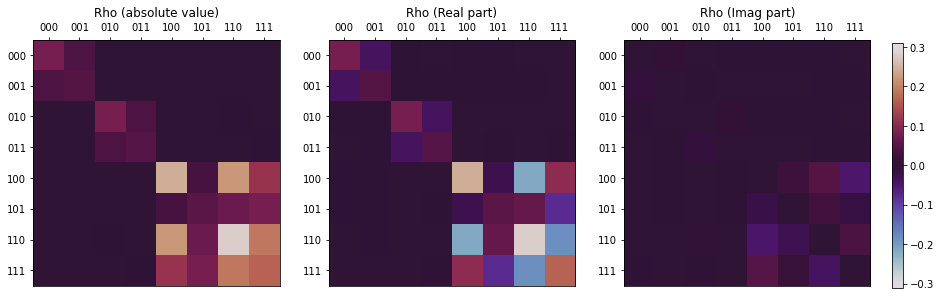

In [104]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.xaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax1.yaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax1.xaxis.tick_top()
ax1.set_title("Rho (absolute value)")
ax2.xaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax2.yaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax2.xaxis.tick_top()
ax2.set_title("Rho (Real part)")
ax3.xaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax3.yaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax3.xaxis.tick_top()
ax3.set_title("Rho (Imag part)")

pNorm = plt.Normalize(-0.31,0.31,clip=False)
adat=dZ_targ_abs.reshape(8,8,-1)
rdat=dZ_targ_re.reshape(8,8,-1)
idat=dZ_targ_im.reshape(8,8,-1)

ax1.imshow(adat,norm=pNorm,cmap='twilight')
ax2.imshow(rdat,norm=pNorm,cmap='twilight')
ax3.imshow(idat,norm=pNorm,cmap='twilight')

cax = plt.axes([0.92,0.155,0.01,0.68])
plt.colorbar(plt.cm.ScalarMappable(norm=pNorm,cmap='twilight'),cax=cax)

# os.chdir("/Users/edrazor/Downloads/")
# plt.savefig('rho_targ_mixed.pdf')

plt.show()

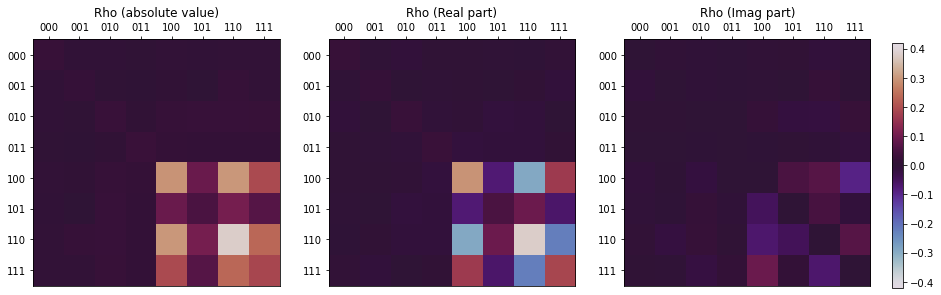

In [47]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.xaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax1.yaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax1.xaxis.tick_top()
ax1.set_title("Rho (absolute value)")
ax2.xaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax2.yaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax2.xaxis.tick_top()
ax2.set_title("Rho (Real part)")
ax3.xaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax3.yaxis.set_ticks([0,1,2,3,4,5,6,7],labels=['000','001','010','011','100','101','110','111'])
ax3.xaxis.tick_top()
ax3.set_title("Rho (Imag part)")

pNorm = plt.Normalize(-0.42,0.42,clip=False)
adat=dZ_exp_abs.reshape(8,8,-1)
rdat=dZ_exp_re.reshape(8,8,-1)
idat=dZ_exp_im.reshape(8,8,-1)

ax1.imshow(adat,norm=pNorm,cmap='twilight')
ax2.imshow(rdat,norm=pNorm,cmap='twilight')
ax3.imshow(idat,norm=pNorm,cmap='twilight')

cax = plt.axes([0.92,0.155,0.01,0.68])
plt.colorbar(plt.cm.ScalarMappable(norm=pNorm,cmap='twilight'),cax=cax)

# os.chdir("/Users/edrazor/Downloads/")
# plt.savefig('rho_exp.pdf')

plt.show()

In [32]:
np.trace(fmpow(np.matmul(np.matmul(fmpow(rho_exp,0.5),rho_targ),fmpow(rho_exp,0.5)),0.5))

(0.9200023754173903+3.864086616436037e-10j)

In [34]:
np.max(dZ_exp_abs)

0.38043819041879956